# Pytorch-预训练VGG中间层可解释性分析

使用shap库的`GradientExplainer`，对预训练VGG16模型的中间层输出，计算shap值。

同济子豪兄 https://space.bilibili.com/1900783

代码运行云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1

2022-10-24

## 导入工具包

In [1]:
import torch, torchvision
from torch import nn
from torchvision import transforms, models, datasets
import shap
import json
import numpy as np

## 载入模型

In [2]:
# load the model
model = models.vgg16(pretrained=True).eval()

## 载入数据集，预处理

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

## 指定测试图像

In [4]:
X, y = shap.datasets.imagenet50()

X /= 255

to_explain = X[[39, 41]]

## 载入类别和索引号

In [5]:
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

## 计算模型中间层，在输入图像上的shap值

In [7]:
# 指定中间层
layer_index = 7 

# 迭代次数，200次大约需计算 5 分钟
samples = 200

In [8]:
e = shap.GradientExplainer((model, model.features[layer_index]), normalize(X))
shap_values,indexes = e.shap_values(normalize(to_explain), ranked_outputs=2, nsamples=samples)

## 预测类别名称

In [9]:
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

In [10]:
index_names

array([['dowitcher', 'red-backed_sandpiper'],
       ['meerkat', 'mongoose']], dtype='<U20')

## 可视化

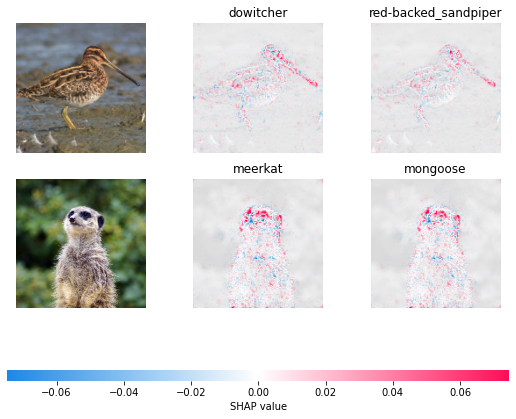

In [11]:
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

## 在图像上引入局部平滑

Gradient explainer的期望梯度，融合了integrated gradients, SHAP, SmoothGrad的思想，只需将`local_smoothing`参数设置为非0即可。在计算期望时，在输入图像加入正态分布噪声，绘制出更平滑的显著性分析图。

In [12]:
# 计算模型中间层，在输入图像上的shap值
explainer = shap.GradientExplainer((model, model.features[layer_index]), normalize(X), local_smoothing=0.5)
shap_values, indexes = explainer.shap_values(normalize(to_explain), ranked_outputs=2, nsamples=samples)

In [13]:
# 预测类别名称
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

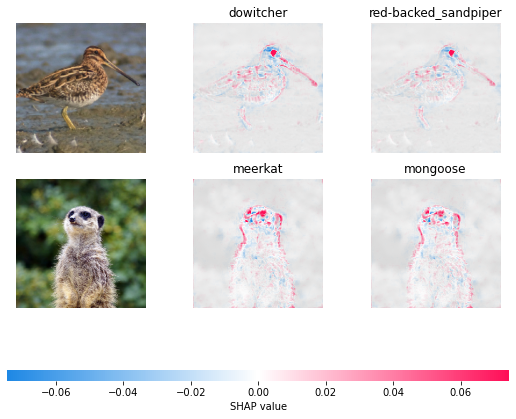

In [14]:
# 可视化
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

可以看出，模型浅层输出的显著性分析图，虽然具有细粒度、高分辨率，但不具有类别判别性（class discriminative）。

模型深层输出的显著性分析图，虽然分辨率较低，但具有类别判别性。